In [1]:
# Step 1: Install necessary libraries in the Colab environment
!pip install -q transformers torch Pillow requests

In [2]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image, UnidentifiedImageError  # <-- FIX: Import UnidentifiedImageError here
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from io import BytesIO

In [3]:
# --- Helper Function for Visualization Palette ---
def ade_palette():
    """Creates a color palette for the ADE20K dataset for visualization."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50], [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255], [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7], [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82], [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3], [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255], [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220], [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224], [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255], [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7], [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153], [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255], [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0], [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255], [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255], [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255], [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0], [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0], [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255], [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255], [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 122], [255, 184, 0], [0, 255, 61], [0, 71, 255], [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255], [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255], [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0], [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0], [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255], [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112], [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160], [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 153], [255, 82, 0], [255, 214, 0], [255, 0, 194], [255, 0, 163], [255, 143, 0], [51, 153, 255], [153, 255, 0], [0, 255, 235], [255, 245, 0], [163, 255, 0], [122, 255, 0], [214, 255, 0], [0, 82, 255], [0, 255, 204], [204, 0, 255], [255, 204, 0], [0, 255, 224], [0, 153, 255], [255, 0, 71], [10, 255, 0], [153, 0, 255]]


In [4]:
# --- NEW: Robust URL Image Loader ---
def load_image_from_url(url: str) -> Image.Image:
    """
    Safely downloads an image from a URL and returns a PIL Image.
    Handles common errors like bad URLs or non-image content.
    """
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        response = requests.get(url, stream=True, headers=headers, timeout=10)
        # Raise an exception for bad status codes (4xx or 5xx)
        response.raise_for_status()

        # Use BytesIO to handle the image data in memory
        image_data = BytesIO(response.content)

        # Open the image
        image = Image.open(image_data).convert("RGB")
        return image

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image from URL: {e}")
        return None
    except UnidentifiedImageError:
        print(f"Error: The content at the URL is not a recognizable image format.")
        return None

In [5]:
class SemanticSegmenter:
    """A class to encapsulate the SegFormer model and processing logic."""
    def __init__(self, model_name="nvidia/segformer-b0-finetuned-ade-512-512"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_name = model_name
        self.processor = SegformerImageProcessor.from_pretrained(self.model_name)
        self.model = SegformerForSemanticSegmentation.from_pretrained(self.model_name).to(self.device)
        self.palette = ade_palette()
        print(f"SemanticSegmenter initialized with model {self.model_name} on {self.device}")

    def get_segmentation_map(self, image: Image.Image) -> np.ndarray:
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(
            logits, size=image.size[::-1], mode='bilinear', align_corners=False
        )
        pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
        return pred_seg

    def pred_seg_to_color_mask(self, pred_seg: np.ndarray) -> Image.Image:
        color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
        palette_np = np.array(self.palette)
        for label, color in enumerate(palette_np):
            color_seg[pred_seg == label, :] = color
        return Image.fromarray(color_seg)

    def predict(self, image: Image.Image) -> Image.Image:
        pred_seg = self.get_segmentation_map(image)
        color_mask = self.pred_seg_to_color_mask(pred_seg)
        return color_mask

    def extract_class_mask(self, pred_seg: np.ndarray, class_id: int) -> Image.Image:
        mask = np.where(pred_seg == class_id, 255, 0).astype(np.uint8)
        return Image.fromarray(mask)

    def get_detected_objects(self, pred_seg: np.ndarray) -> dict:
        unique_ids = np.unique(pred_seg)
        detected = {}
        for class_id in unique_ids:
            label_name = self.model.config.id2label.get(class_id, "unknown")
            detected[class_id] = label_name
        return detected

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

SemanticSegmenter initialized with model nvidia/segformer-b5-finetuned-ade-640-640 on cuda
Loading image from: https://focastock.b-cdn.net/photos/P805090320221114.jpg?quality=70&auto=format&width=800
Image loaded successfully. Re-processing to create a complete vehicle mask...

Detected objects:
{np.int64(1): 'building', np.int64(2): 'sky', np.int64(6): 'road', np.int64(11): 'sidewalk', np.int64(12): 'person', np.int64(20): 'car', np.int64(40): 'base', np.int64(43): 'signboard', np.int64(80): 'bus', np.int64(86): 'awning', np.int64(87): 'streetlight', np.int64(123): 'trade name', np.int64(136): 'traffic light', np.int64(138): 'ashcan'}

Found vehicle classes with IDs: [np.int64(20), np.int64(80)]
Extracting a combined mask for: ['car', 'bus']
Final combined vehicle mask saved to 'vehicle_mask.png'


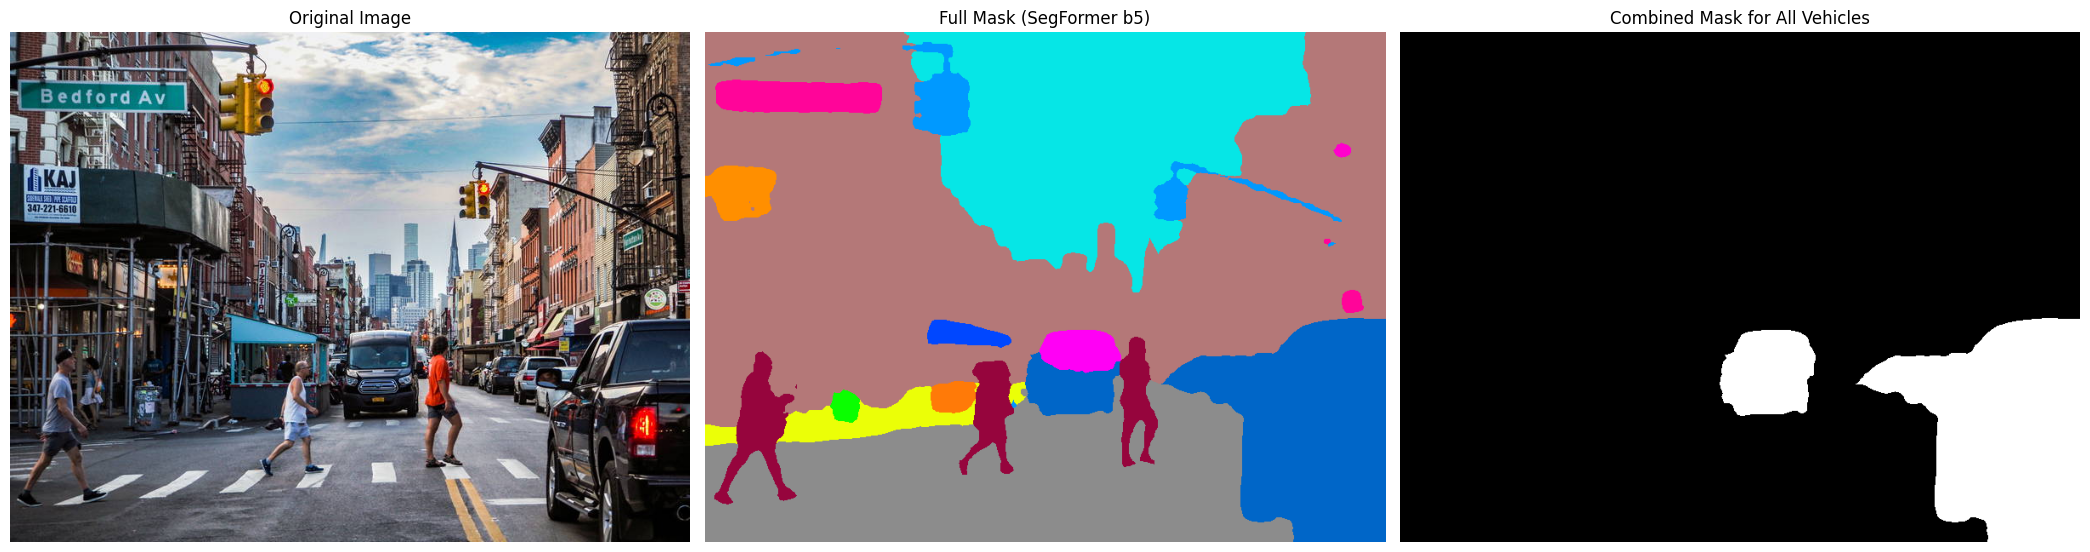

In [6]:
if __name__ == "__main__":
    # URL for the street scene image
    IMAGE_URL = "https://focastock.b-cdn.net/photos/P805090320221114.jpg?quality=70&auto=format&width=800"
    segmenter = SemanticSegmenter(model_name="nvidia/segformer-b5-finetuned-ade-640-640")



    print(f"Loading image from: {IMAGE_URL}")
    input_image = load_image_from_url(IMAGE_URL)

    if input_image:
        print("Image loaded successfully. Re-processing to create a complete vehicle mask...")

        # We already have the segmenter object, so we can reuse it.
        # Let's re-run the prediction to ensure the map is in memory.
        pred_seg_map = segmenter.get_segmentation_map(input_image)
        color_mask = segmenter.pred_seg_to_color_mask(pred_seg_map)
        detected_objects = segmenter.get_detected_objects(pred_seg_map)

        print("\nDetected objects:")
        print(detected_objects)

        # --- THE FIX: Create a more comprehensive list of vehicle types ---
        target_class_names = ['car', 'truck', 'bus', 'van']

        target_class_ids = [k for k, v in detected_objects.items() if v in target_class_names]

        if target_class_ids:
            print(f"\nFound vehicle classes with IDs: {target_class_ids}")
            print(f"Extracting a combined mask for: {[detected_objects[i] for i in target_class_ids]}")

            # Create a combined mask from all found vehicle classes
            combined_mask_np = np.zeros_like(pred_seg_map, dtype=np.uint8)
            for class_id in target_class_ids:
                combined_mask_np[pred_seg_map == class_id] = 255

            combined_mask_image = Image.fromarray(combined_mask_np)

            # Save the final, most useful mask
            final_mask_filename = "vehicle_mask.png"
            combined_mask_image.save(final_mask_filename)
            print(f"Final combined vehicle mask saved to '{final_mask_filename}'")

            # Visualize everything
            fig, ax = plt.subplots(1, 3, figsize=(21, 7))
            ax[0].imshow(input_image)
            ax[0].set_title("Original Image")
            ax[0].axis('off')
            ax[1].imshow(color_mask)
            ax[1].set_title("Full Mask (SegFormer b5)")
            ax[1].axis('off')
            ax[2].imshow(combined_mask_image, cmap='gray')
            ax[2].set_title(f"Combined Mask for All Vehicles")
            ax[2].axis('off')
            plt.tight_layout()
            plt.show()

        else:
            print(f"\nCould not find any of {target_class_names} in the image.")
    else:
        print("\nCould not process the image. Please check the URL and try again.")

# Image generation

In [7]:
!pip install -q diffusers transformers accelerate torch Pillow opencv-python


In [8]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import numpy as np

Using device: cuda


config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


ControlNet pipeline loaded successfully.
Successfully loaded and resized control mask: 'vehicle_mask.png'


  0%|          | 0/25 [00:00<?, ?it/s]

Generated image saved to 'generated_vehicles.png'


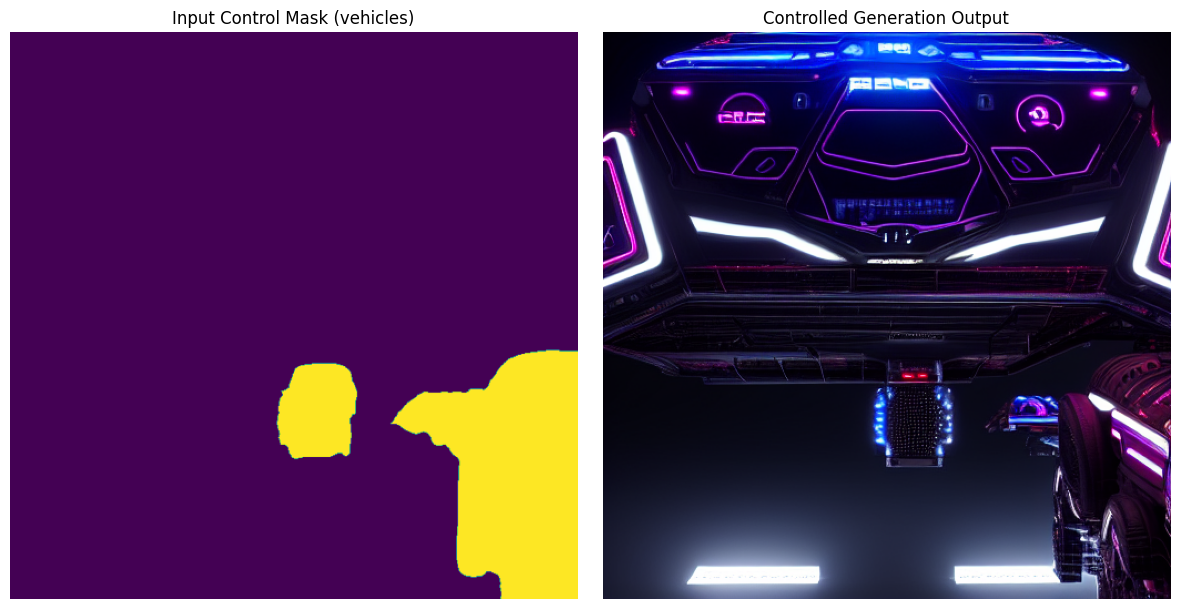

Cleaned up GPU memory.


In [9]:
# Step 2: Proactive VRAM Management for Colab
# Ensure the GPU is clean before loading large models.
torch.cuda.empty_cache()

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# This ControlNet was specifically trained to understand segmentation maps.
CONTROLNET_MODEL_NAME = "lllyasviel/control_v11p_sd15_seg"
# A popular base model for generating images.
STABLE_DIFFUSION_MODEL_NAME = "runwayml/stable-diffusion-v1-5"

print(f"Using device: {DEVICE}")

# --- Step 3: Model Loading (with VRAM optimizations) ---
# Load the ControlNet model in half-precision (float16) to save memory.
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL_NAME,
    torch_dtype=torch.float16
)

# Load the full Stable Diffusion pipeline, also in float16.
# Pass the loaded controlnet model directly to it.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    STABLE_DIFFUSION_MODEL_NAME,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None # Disabling saves VRAM.
).to(DEVICE)

# --- Performance Optimization ---
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
print("ControlNet pipeline loaded successfully.")


# --- Step 4: Load Your Real Mask ---
# This is the key integration step. We are loading the output from the segmentation script.
# Make sure 'vehicle_mask.png' is in your Colab session files.
mask_filename = "vehicle_mask.png"
control_mask = Image.open(mask_filename)

# Proactive Check: Ensure mask is the right size for Stable Diffusion v1.5
# The model was trained on 512x512 images. The control image must match.
control_mask = control_mask.resize((512, 512))

print(f"Successfully loaded and resized control mask: '{mask_filename}'")

# --- Step 5: Define The Generative Prompt ---
# The prompt provides the content and style. The mask provides the structure.
prompt = "a futuristic armored cyberpunk truck, neon lights, intricate details, 8k, photorealistic"
negative_prompt = "cartoon, drawing, sketch, ugly, blurry, worst quality, low quality"


# --- Step 6: Generate the Image ---
def generate_controlled_image(control_image: Image.Image, prompt: str, negative_prompt: str) -> Image.Image:
    """Encapsulates the generation logic."""
    generator = torch.manual_seed(42) # for reproducible results
    output = pipe(
        prompt,
        image=control_image, # This is where the mask controls the generation
        negative_prompt=negative_prompt,
        num_inference_steps=25, # Higher steps can improve quality
        guidance_scale=7.5,
        generator=generator
    )
    return output.images[0]

generated_image = generate_controlled_image(control_mask, prompt, negative_prompt)
generated_image.save("generated_vehicles.png")
print("Generated image saved to 'generated_vehicles.png'")


# --- Step 7: Visualize the Results ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(control_mask)
ax[0].set_title("Input Control Mask (vehicles)")
ax[0].axis('off')

ax[1].imshow(generated_image)
ax[1].set_title("Controlled Generation Output")
ax[1].axis('off')

plt.tight_layout()
plt.show()

# --- Step 8: Proactive Cleanup ---
del pipe
del controlnet
torch.cuda.empty_cache()
print("Cleaned up GPU memory.")


Loading original image...
Loading generated content and control mask...
All images resized to 512x512.
Compositing complete.


/tmp/ipython-input-1762196825.py:60: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


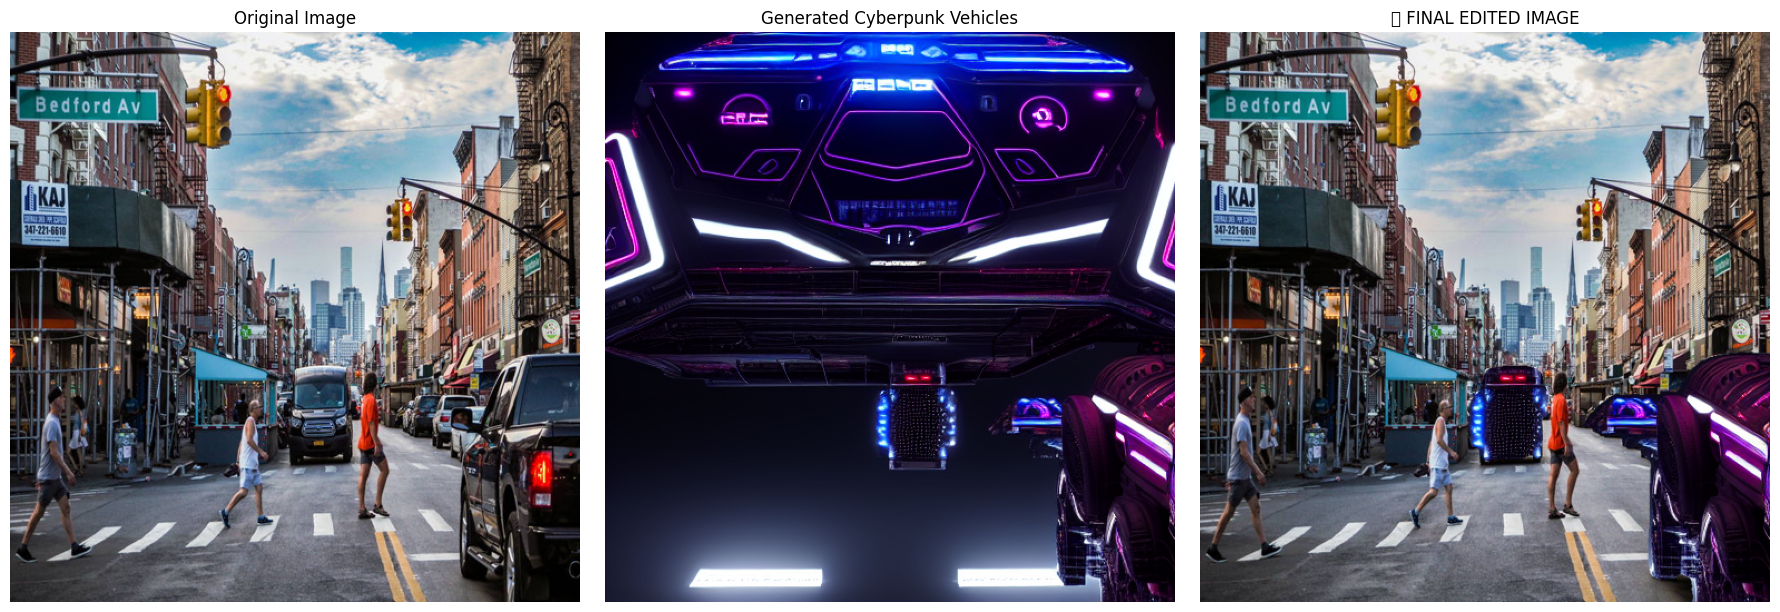

Final edited image saved to 'final_edit.png'


In [10]:
from PIL import Image
from io import BytesIO
import requests

# --- 1. Define the robust URL loader again (since it's in a new cell) ---
def load_image_from_url(url: str) -> Image.Image:
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        response = requests.get(url, stream=True, headers=headers, timeout=10)
        response.raise_for_status()
        image_data = BytesIO(response.content)
        image = Image.open(image_data).convert("RGB")
        return image
    except Exception as e:
        print(f"Error loading image from URL: {e}")
        return None

# --- 2. Load all three necessary images ---
# The original image URL
original_image_url = "https://focastock.b-cdn.net/photos/P805090320221114.jpg?quality=70&auto=format&width=800"
print("Loading original image...")
original_image = load_image_from_url(original_image_url)

# The generated content and the mask (from local files)
print("Loading generated content and control mask...")
generated_image = Image.open("generated_vehicles.png")
control_mask = Image.open("vehicle_mask.png")

# --- 3. Ensure all images are the same size ---
if original_image:
    target_size = (512, 512)
    original_image = original_image.resize(target_size)
    generated_image = generated_image.resize(target_size)
    # The mask needs to be grayscale (L mode) for compositing
    control_mask = control_mask.resize(target_size).convert("L")
    print("All images resized to 512x512.")

    # --- 4. Composite the final image ---
    # The logic is: "where the mask is white, use the generated image;
    # where the mask is black, use the original image."
    final_edited_image = Image.composite(generated_image, original_image, control_mask)
    print("Compositing complete.")

    # --- 5. Visualize the complete end-to-end result ---
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(generated_image)
    ax[1].set_title("Generated Cyberpunk Vehicles")
    ax[1].axis('off')

    ax[2].imshow(final_edited_image)
    ax[2].set_title("✅ FINAL EDITED IMAGE")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    final_edited_image.save("final_edit.png")
    print("Final edited image saved to 'final_edit.png'")
else:
    print("Could not load the original image to perform inpainting.")